## Train Model

In [1]:
import h5py
import sys
import mpra_model
import numpy as np
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from sklearn import model_selection
import scipy.stats
celltype = 'K562'
file = '/home/ztang/multitask_RNA/data/lenti_MPRA/'+celltype+'_onehot.h5'
save_model = '/home/ztang/multitask_RNA/model/lenti_MPRA_onehot/'+celltype+'/model.h5'

2023-05-04 16:56:08.363971: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 16:56:08.893127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
f = h5py.File(file, 'r')
x = f['onehot'][()]
y = f['target'][()]
x = np.swapaxes(x,1,2)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.1,random_state=42)

In [3]:
model = mpra_model.ResNet((230,4),1)
earlyStopping_callback = tf.keras.callbacks.EarlyStopping(
            patience=10, restore_best_weights=True
        )
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.2,
            patience=5, min_lr=1e-6)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_model,
                                    monitor='val_loss',
                                    save_best_only=True,
                                    mode = 'min',
                                    save_freq='epoch',)
model.compile(
                loss="mean_squared_error",
                metrics=["mse", "mae"],
                optimizer=optimizer,
            )

2023-05-04 16:56:10.816198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78865 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:07:00.0, compute capability: 8.0
/home/ztang/.conda/envs/jax_tf/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [4]:
result = model.fit(x_train,y_train,
        batch_size=128,
        validation_split=0.1,
        epochs=100,
        shuffle=True,
        verbose=2,
        callbacks=[earlyStopping_callback,checkpoint,reduce_lr],
    )


Epoch 1/100


2023-05-04 16:56:15.892459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-04 16:56:16.448433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-04 16:56:16.450228: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x561001d03be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-04 16:56:16.450245: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-05-04 16:56:16.453624: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-04 16:56:16.561271: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

1432/1432 - 28s - loss: 0.1861 - mse: 0.1861 - mae: 0.3298 - val_loss: 0.1677 - val_mse: 0.1677 - val_mae: 0.3248 - lr: 0.0010 - 28s/epoch - 20ms/step
Epoch 2/100
1432/1432 - 21s - loss: 0.1537 - mse: 0.1537 - mae: 0.2993 - val_loss: 0.1338 - val_mse: 0.1338 - val_mae: 0.2773 - lr: 0.0010 - 21s/epoch - 15ms/step
Epoch 3/100
1432/1432 - 21s - loss: 0.1437 - mse: 0.1437 - mae: 0.2890 - val_loss: 0.1339 - val_mse: 0.1339 - val_mae: 0.2826 - lr: 0.0010 - 21s/epoch - 15ms/step
Epoch 4/100
1432/1432 - 21s - loss: 0.1370 - mse: 0.1370 - mae: 0.2821 - val_loss: 0.1315 - val_mse: 0.1315 - val_mae: 0.2697 - lr: 0.0010 - 21s/epoch - 15ms/step
Epoch 5/100
1432/1432 - 21s - loss: 0.1324 - mse: 0.1324 - mae: 0.2775 - val_loss: 0.1279 - val_mse: 0.1279 - val_mae: 0.2712 - lr: 0.0010 - 21s/epoch - 15ms/step
Epoch 6/100
1432/1432 - 21s - loss: 0.1293 - mse: 0.1293 - mae: 0.2740 - val_loss: 0.1253 - val_mse: 0.1253 - val_mae: 0.2625 - lr: 0.0010 - 21s/epoch - 15ms/step
Epoch 7/100
1432/1432 - 21s - loss

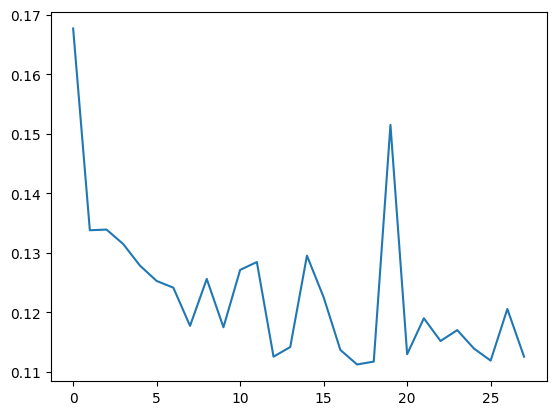

In [5]:
import matplotlib.pyplot as plt
plt.plot(result.history['val_loss'])

In [6]:
y_pred = model.predict(x_test)
scipy.stats.pearsonr(np.squeeze(y_pred),y_test)

708/708 [==============================] - 1s 2ms/step


PearsonRResult(statistic=0.772497329447513, pvalue=0.0)

## Test model on corresponding CAGI

In [1]:
import tensorflow as tf
from tensorflow import keras
import h5py
import scipy.stats
import numpy as np
import os
import pandas as pd
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
celltype = 'K562'

2023-05-04 17:12:45.041688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 17:12:45.625612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = keras.models.load_model('/home/ztang/multitask_RNA/model/lenti_MPRA_onehot/'+celltype+'/model.h5')

2023-05-04 17:12:48.345618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78865 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:07:00.0, compute capability: 8.0
/home/ztang/.conda/envs/jax_tf/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [3]:
file = h5py.File("/home/ztang/multitask_RNA/data/CAGI/"+celltype+"/onehot.h5", "r")
alt = file['alt']
ref = file['ref']
alt_pred = model.predict(alt)
ref_pred = model.predict(ref)
pred = alt_pred - ref_pred
pred.shape

2023-05-04 17:12:51.014371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


45/45 [==============================] - 2s 4ms/step


2023-05-04 17:12:51.563083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


45/45 [==============================] - 0s 2ms/step


(1409, 1)

In [4]:
exp_df = pd.read_csv('/home/ztang/multitask_RNA/data/CAGI/'+celltype+'/metadata.csv')
target = exp_df['6'].values.tolist()

In [5]:
start_idx=0
perf = []
for exp in exp_df['8'].unique():
    sub_df = exp_df[exp_df['8'] == exp]
    exp_target = target[start_idx:sub_df.index[-1]+1]
    exp_pred = np.squeeze(pred)[start_idx:sub_df.index[-1]+1]
    print(exp)
    perf.append(scipy.stats.pearsonr(exp_pred,exp_target)[0])
    print(scipy.stats.pearsonr(exp_pred,exp_target)[0])

PKLR
0.5509142238286401


: 

In [17]:
np.mean(perf)

0.4617297798235596